In [1]:
%tensorflow_version 1.x
import tensorflow as tf
import time
import matplotlib.pyplot as plt
%matplotlib inline
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
cd /content/gdrive/My Drive/

/content/gdrive/My Drive


In [6]:
#pip install python-mnist

In [0]:
from mnist import MNIST

In [8]:
ls emnist_data/

emnist-balanced-test-images-idx3-ubyte.gz
emnist-balanced-test-labels-idx1-ubyte.gz
emnist-balanced-train-images-idx3-ubyte.gz
emnist-balanced-train-labels-idx1-ubyte.gz


In [0]:
emnist = MNIST('emnist_data/')
emnist.select_emnist('balanced')

images,labels = emnist.load_training()
testIM,testLAB = emnist.load_testing()

In [0]:
import numpy as np

In [0]:
n_images = np.array(images)   
n_labels = np.array(labels)   
test_images = np.array(testIM)   
testLAB = np.array(testLAB) 

In [0]:
#fitting data b/w 0 and 1 (for easy calculation)

In [0]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()                                #this makes scaler_model (a variable) an instance of  MinMaxScaler
scaler.fit(n_images)                                   #this fits the data in the model
train_images = scaler.transform(n_images)              #finally this converts the data between the given range.By default, 0 to 1

In [0]:
scaler.fit(testIM)
test_images = scaler.transform(testIM)

In [0]:
#one hot encoding of labels

In [0]:
from sklearn.preprocessing import OneHotEncoder

shaped_n_labels  = n_labels.reshape(-1,1)
enc = OneHotEncoder()
enc.fit(shaped_n_labels)
train_labels = enc.transform(shaped_n_labels).toarray()

shaped_testLAB = testLAB.reshape(-1,1)
enc.fit(shaped_testLAB)
test_labels = enc.transform(shaped_testLAB).toarray()

In [0]:
#naming the labels
labels_dict ={0:0,1:1,2:2,3:3,4:4,5:5,6:6,7:7,8:8,9:9,10:'A',11:'B',12:'C',13:'D',14:'E',
              15:'F',16:'G',17:'H',18:'I',19:'J',20:'K',21:'l',22:'M',23:'N',24:'O',25:'P',
              26:'Q',27:'R',28:'S',29:'T',30:'u',31:'V',32:'W',33:'X',34:'Y',35:'Z',36:'a',
              37:'b',38:'d',39:'e',40:'f',41:'g',42:'h',43:'n',44:'q',45:'r',46:'t'}

# the following characters are left out due to similarity in their upper case and lower case representations (or similarity with other characters)
# L, U, c,i,j,k,m,o,p,s,v,w,x,y,z  (total 15)
#so, characters [a-z] , [A-Z], [0-9] are total 26+26+10=62
#15 are not used. So, remaining no. of labels =62-15=47

In [0]:
# some helper functions:-

In [0]:
# 1) initializing weights
def init_weights(shape):
    init_random_dist=tf.truncated_normal(shape,stddev=0.1)
    """Outputs random values from a truncated normal distribution.
    The generated values follow a normal distribution with specified mean and standard deviation, 
    except that values whose magnitude is more than 2 standard deviations from the mean are dropped 
    and re-picked."""
    """Normal distribution, also known as the Gaussian distribution, is a probability distribution that is 
    symmetric about the mean, showing that data near the mean are more frequent in occurrence than data far 
    from the mean. In graph form, normal distribution will appear as a bell curve."""
    return tf.Variable(init_random_dist)

In [0]:
# 2) initializing bias
def init_bias(shape):
    init_bias_vals=tf.constant(0.1,shape=shape)          # all values are 0.1 and the shape is that of the tensor
    return tf.Variable(init_bias_vals)

In [0]:
# 3) convolutional func
def conv2d(x,W):
    # x is the input tensor.A 4d tensor. its shape:- [batch,height,width,channel]  (channel is 1 for grayscale and 3 for rgb)
    # batch basically tells which all images are being taken as i/p/. height and weight are of individual images. 
    # W is the kernel(or the filter).its shape:- [filter height,filter width,no. of channels as i/p, no. of channels as o/p ]
    return tf.nn.conv2d(x,W,strides=[1,1,1,1],padding='SAME')    
                        # basic 2d convolutional function

In [0]:
# 4) pooling
def max_pool_2by2(x):
    # x is the input tensor. its shape:- [batch,height,width,channel] 
    return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME")
                # pooling is done only along height and width. so, it is basically 2*2 pooling
                # ksize specifies the size of the window for each dimension of input tensor
                # stride specifies the stride of the sliding window for each dimension of input tensor

In [0]:
# convolutional layer
def convolutional_layer(input_x,shape):
    w=init_weights(shape)
    b=init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x,w)+b)

In [0]:
# normal (or, fully connected) layer
def normal_full_layer(input_layer,size):
    input_size=int(input_layer.get_shape()[1])
    w=init_weights([input_size,size])
    b=init_bias([size])
    return tf.matmul(input_layer,w)+b

In [0]:
# placeholder
x=tf.placeholder(tf.float32,shape=[None,784])
y_true=tf.placeholder(tf.float32,shape=[None,47])

In [0]:
# layers
x_image= tf.reshape(x,[-1,28,28,1])   # converting the i/p img back to layers. The 28*28 is h*w. 1 is coz of grayscale.

In [0]:
# first convolutional layer
convo_1=convolutional_layer(x_image,shape=[5,5,1,32]) # the wt. tensor is [5,5,1,32]
                                                      # 5 by 5 convolutional layer. so, this convolution will compute
                                                      # 32 features for each 5 by 5 patch. 1 is the i/p channels.32 is the no.
                                                      # of o/p channels.

In [0]:
# first pooling layer
convo_1_pooling = max_pool_2by2(convo_1)

In [0]:
# second convolutional layer
convo_2 = convolutional_layer(convo_1_pooling,shape=[5,5,32,64])    # 64 features
convo_2_pooling= max_pool_2by2(convo_2)

In [0]:
#this o/p is now flattened out so that it gets connected to a fully connected layer
convo_2_flat= tf.reshape(convo_2_pooling,[-1,7*7*64])
#here 7*7 is dimension of each image. here's how:-
#28*28 on pooling with 2*2 gives 14*14
#14*14 on pooling with 2*2 gives 7*7
#NOTE:- the dimension of the image didn't change on convolution as "SAME" type of convolution is used.Meaning to say that the padding is such that the final
#       o/p dimension remains the same.here, padding=(f-1)/2=(5-1)/2=2 . so after padding , 28*28 becomes 32*32. and on convolution gives 28*28 
#       (as, n-f+1=32-5+1=28  )
full_layer_one=tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [31]:
# dropout
hold_prob= tf.placeholder(tf.float32)
full_one_dropout= tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
y_pred= normal_full_layer(full_one_dropout,47)    # 47 is the no. of labels

In [33]:
# loss function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [0]:
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0005)
train =  optimizer.minimize(cross_entropy)

In [0]:
init= tf.global_variables_initializer()

In [0]:
saver = tf.train.Saver()

In [37]:
start = time.time()
steps=6000
with tf.Session() as sess:
    sess.run(init)
    
    for i in range(steps):
        #batch_x,batch_y= train_images.next_batch(50)
        rand_idx=np.random.randint(0,112800,90)
        batch_x= train_images[rand_idx]
        batch_y=train_labels[rand_idx]
        sess.run(train,feed_dict={x:batch_x,y_true:batch_y,hold_prob:0.5})   
                                    # hold_prob:0.5 implies every neuron has a 50% hold probablity
        if(i%100==0):
            print("On Step: {}".format(i))
            print("Accuracy:  ")
            matches=tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))
            #argmax(input, axis=None, name=None, dimension=None) Returns the index with the largest value across axis of a tensor
            
            acc=tf.reduce_mean(tf.cast(matches,tf.float32))
            print(sess.run(acc,feed_dict={x:test_images,y_true:test_labels,hold_prob:1.0}))
            # during testing we don't want to dropout any of the neurons. So, we write hold_prob:1.0 , meaning that every neuron will be held at its 
            # position and none will be dropped out
            print('\n')

            saver.save(sess,'model_char_recog.ckpt')
end = time.time()

On Step: 0
Accuracy:  
0.019627659


On Step: 100
Accuracy:  
0.59590423


On Step: 200
Accuracy:  
0.7154787


On Step: 300
Accuracy:  
0.74787235


On Step: 400
Accuracy:  
0.7831383


On Step: 500
Accuracy:  
0.80281913


On Step: 600
Accuracy:  
0.8089362


On Step: 700
Accuracy:  
0.8161702


On Step: 800
Accuracy:  
0.8249468


On Step: 900
Accuracy:  
0.83292556


On Step: 1000
Accuracy:  
0.8323404


On Step: 1100
Accuracy:  
0.8324468


On Step: 1200
Accuracy:  
0.83904254


On Step: 1300
Accuracy:  
0.8431383


On Step: 1400
Accuracy:  
0.8423404


On Step: 1500
Accuracy:  
0.84760636


On Step: 1600
Accuracy:  
0.8498404


On Step: 1700
Accuracy:  
0.85218084


On Step: 1800
Accuracy:  
0.8567553


On Step: 1900
Accuracy:  
0.85457444


On Step: 2000
Accuracy:  
0.85781914


On Step: 2100
Accuracy:  
0.8580319


On Step: 2200
Accuracy:  
0.85867023


On Step: 2300
Accuracy:  
0.85712767


On Step: 2400
Accuracy:  
0.85877657


On Step: 2500
Accuracy:  
0.85952127


On Step: 

In [0]:
# predicting on single examples

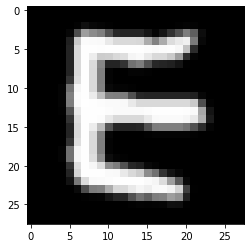

In [38]:
image_index = 444
single_image = train_images[image_index].reshape(28,28) 
plt.imshow(single_image,cmap='gist_gray') 

In [39]:
with tf.Session() as sess:
  sess.run(init)
  saver.restore(sess, "model_char_recog.ckpt")
       
  single_image = train_images[image_index]     
  prediction=tf.argmax(y_pred,1)
  var = prediction.eval(feed_dict={x: [single_image],y_true:train_labels,hold_prob: 1.0}, session=sess)
  print("The predicted character is :- " + str(labels_dict[var[0]]))

INFO:tensorflow:Restoring parameters from model_char_recog.ckpt
The predicted character is :- E


In [0]:
# predicting on images given by user

In [0]:
#function to convert user image into image suitable for the dataset

In [0]:
from PIL import Image, ImageFilter


def imageprepare(argv):
    """
    This function returns the pixel values.
    The imput is a png file location.
    """
    im = Image.open(argv).convert('L')
    width = float(im.size[0])
    height = float(im.size[1])
    newImage = Image.new('L', (28, 28), (255))  # creates white canvas of 28x28 pixels

    if width > height:  # check which dimension is bigger
        # Width is bigger. Width becomes 20 pixels.
        nheight = int(round((28.0 / width * height), 0))  # resize height according to ratio width
        if (nheight == 0):  # rare case but minimum is 1 pixel
            nheight = 1
            # resize and sharpen
        img = im.resize((28, nheight), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wtop = int(round(((28 - nheight) / 2), 0))  # calculate horizontal position
        newImage.paste(img, (0, wtop))  # paste resized image on white canvas
    else:
        # Height is bigger. Heigth becomes 20 pixels.
        nwidth = int(round((28.0 / height * width), 0))  # resize width according to ratio height
        if (nwidth == 0):  # rare case but minimum is 1 pixel
            nwidth = 1
            # resize and sharpen
        img = im.resize((nwidth, 28), Image.ANTIALIAS).filter(ImageFilter.SHARPEN)
        wleft = int(round(((28 - nwidth) / 2), 0))  # caculate vertical pozition
        newImage.paste(img, (wleft, 0))  # paste resized image on white canvas

    # newImage.save("sample.png

    tv = list(newImage.getdata())  # get pixel values

    # normalize pixels to 0 and 1. 0 is pure white, 1 is pure black.
    tva = [(255 - x) * 1.0 / 255.0 for x in tv]
    #print(tva)
    for i in range(len(tva)):
        if tva[i]<=0.45:
            tva[i]=0.0
    return tva

In [0]:
my_img=imageprepare('./P.jpg')#file path here

In [0]:
my_img=np.array(my_img)

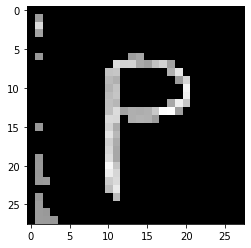

In [45]:
plt.imshow(my_img.reshape(28,28),cmap='gist_gray') 

In [46]:
with tf.Session() as sess:
  sess.run(init)
  saver.restore(sess, "model_char_recog.ckpt")
     
  prediction=tf.argmax(y_pred,1)
  var = prediction.eval(feed_dict={x: [my_img],y_true:train_labels,hold_prob: 1.0}, session=sess)
  print("The predicted character is :- " + str(labels_dict[var[0]]))

INFO:tensorflow:Restoring parameters from model_char_recog.ckpt
The predicted character is :- P


In [0]:
# example 2

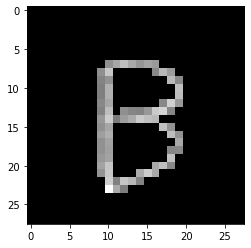

In [47]:
my_img=imageprepare('./B.jpg')#file path here
my_img=np.array(my_img)
plt.imshow(my_img.reshape(28,28),cmap='gist_gray') 

In [48]:
with tf.Session() as sess:
  sess.run(init)
  saver.restore(sess, "model_char_recog.ckpt")
     
  prediction=tf.argmax(y_pred,1)
  var = prediction.eval(feed_dict={x: [my_img],y_true:train_labels,hold_prob: 1.0}, session=sess)
  print("The predicted character is :- " + str(labels_dict[var[0]]))

INFO:tensorflow:Restoring parameters from model_char_recog.ckpt
The predicted character is :- B


In [0]:
#example 3

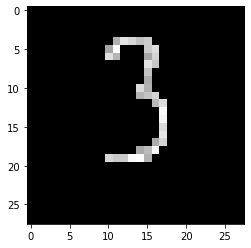

In [59]:
my_img=imageprepare('./3.jpg')#file path here
my_img=np.array(my_img)
plt.imshow(my_img.reshape(28,28),cmap='gist_gray') 

In [61]:
with tf.Session() as sess:
  sess.run(init)
  saver.restore(sess, "model_char_recog.ckpt")
     
  prediction=tf.argmax(y_pred,1)
  var = prediction.eval(feed_dict={x: [my_img],y_true:train_labels,hold_prob: 1.0}, session=sess)
  print("The predicted character is :- " + str(labels_dict[var[0]]))

INFO:tensorflow:Restoring parameters from model_char_recog.ckpt
The predicted character is :- J


In [0]:
#example 4

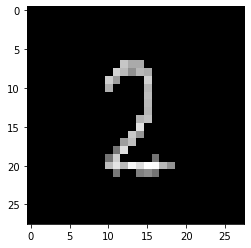

In [66]:
my_img=imageprepare('./2.jpg')#file path here
my_img=np.array(my_img)
plt.imshow(my_img.reshape(28,28),cmap='gist_gray') 

In [67]:
with tf.Session() as sess:
  sess.run(init)
  saver.restore(sess, "model_char_recog.ckpt")
     
  prediction=tf.argmax(y_pred,1)
  var = prediction.eval(feed_dict={x: [my_img],y_true:train_labels,hold_prob: 1.0}, session=sess)
  print("The predicted character is :- " + str(labels_dict[var[0]]))

INFO:tensorflow:Restoring parameters from model_char_recog.ckpt
The predicted character is :- 2
